<a href="https://colab.research.google.com/github/Igor-Belskiy/AI_University/blob/main/%D0%91%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%B8%D0%BB%D0%B5%D0%B9_%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка данных и распознавание стилей музыки с помощью Dense сети

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

In [ ]:
import gdown
gdown.download('https://drive.google.com/u/0/uc?id=1XsFcjb8aR7RYzHbCZqTrhv7tBTn--ySq', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1XsFcjb8aR7RYzHbCZqTrhv7tBTn--ySq
To: /content/genres.zip
100%|██████████| 1.23G/1.23G [00:22<00:00, 55.4MB/s]


'genres.zip'

In [ ]:
!unzip -q '/content/genres.zip' #распаковываем архив на google диске на локальный диск google colaboratory

genres = os.listdir('genres') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls genres
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Выводим список жанров
print(genres)

['classical', 'reggae', 'jazz', 'country', 'disco', 'metal', 'hiphop', 'pop', 'rock', 'blues']


In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)

  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда


  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля

  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))

  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)

    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр classical готов -> 72c
Жанр reggae готов -> 57c
Жанр jazz готов -> 66c
Жанр country готов -> 61c
Жанр disco готов -> 71c
Жанр metal готов -> 64c
Жанр hiphop готов -> 56c
Жанр pop готов -> 61c
Жанр rock готов -> 53c
Жанр blues готов -> 53c


In [ ]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-1.75031256 -1.28580476 -1.40618124 -1.35430671 -1.05771482 -2.74274188
  0.89082589  0.23718246 -0.78589637 -0.26064538 -0.89597771 -0.30961497
 -1.69596757 -0.00937897 -1.34275867 -0.20345469 -1.47580431 -0.69724557
 -2.47657974 -0.38340733 -0.33674723  2.41806195  1.31502021 -0.30523632
 -1.06346506 -2.04699368 -0.4960336  -0.74660492  0.30540485 -0.87441084
 -2.30619952 -1.79168226 -1.11593862 -1.45063813 -0.89390099 -1.44317222
 -1.66796454]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


#Cоздаём нейронную сеть

Epoch 1/200
45/45 [==============================] - 1s 9ms/step - loss: 1.5601 - accuracy: 0.4411 - val_loss: 1.3426 - val_accuracy: 0.5300
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1767 - accuracy: 0.6000 - val_loss: 1.3057 - val_accuracy: 0.5300
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0218 - accuracy: 0.6544 - val_loss: 1.2048 - val_accuracy: 0.5800
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 0.9309 - accuracy: 0.6856 - val_loss: 1.2349 - val_accuracy: 0.5400
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 0.8588 - accuracy: 0.7089 - val_loss: 1.1884 - val_accuracy: 0.5900
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 0.7809 - accuracy: 0.7400 - val_loss: 1.1964 - val_accuracy: 0.5600
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 0.7325 - accuracy: 0.7500 - val_loss: 1.2291 - val_accuracy: 0.5700
Epoch 8/200
4

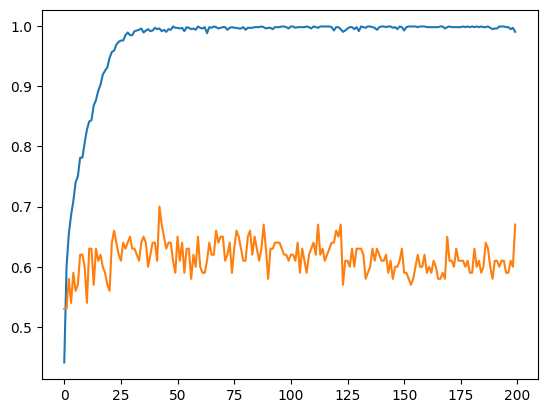

In [ ]:
#Указываем, какие индексы данных во входных векторах брать для обучения
#Делаем это для того, чтобы можно было экспериментировать
#И обучать не на всех колонках данных, а на части
indexes = range(0,37)

#Создаём полносвязанную сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

 # Распознавание выбранной песни

In [ ]:
#Выбираем песню для распознавания
songname = '/content/genres/metal/metal.00001.au'
#Получаем аудио сигнал
y, sr = librosa.load(songname, mono=True, duration=30)
#Параметризуем сигнал
out = get_features(y, sr)

In [ ]:
#Добавляем одну размерность, этого требует model.predict
out = np.array(out).reshape(1,37)

In [ ]:
#Проверяем размерность
out.shape

(1, 37)

In [ ]:
#Делаем преобразование
#С помощью scaler, обученного на обучающей выборке
out = scaler.transform(out)

In [ ]:
#Выводим нормированный вектор
print(out)

[[-0.51206952  1.00757645  0.71901584  0.93087949  1.17819022  0.64234187
  -1.10849885 -0.30166966  0.63312934  0.74176512  0.60215497  0.2975261
   1.13439306 -0.08630233  0.4302566   0.25473148  1.0381528  -0.90242795
   1.98611208 -0.66180177  1.04496818 -1.11181523  1.29244889 -1.03136291
   1.10024448  0.40489946  1.68118446  1.01712772  1.77548103  0.55559628
   0.67478655  0.91388353  0.09812061  0.64106944  0.43290391  1.14262125
   0.81631591]]


In [ ]:
#Делаем predict
y = model.predict(out)

1/1 [==============================] - 0s 118ms/step


In [ ]:
#Выводим выход
print(y)
#И распознанный класс
print(np.argmax(y))
#Проверяем правильный индекс исходного жанра
print(genres.index("metal"))

[[1.1080226e-23 2.2060073e-21 1.2086951e-29 4.0303440e-16 2.4644429e-12
  1.0000000e+00 1.5641910e-11 4.8638935e-25 2.8414554e-13 2.8513558e-22]]
5
5
